# Promoter region methylation-RNAseq correlation

### Mamie Wang (szmamie@stanford.edu)
### 2018/02/27

## This note aims to explore the correlation between methylation M value and RNA-seq RSEM level for HM 450K 

## objective
- subset probes with `UCSC_RefGene_Group` as `TSS1500` (within 200 bp - 1500 bp upstream of the transcription start site)
- subset probes at CpG island and shore
- compute the correlation between methylation and corresponding gene expression level

In [2]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Illumina HumanMethylation 450 manifest file
- UCSC_RefGene_Group: functional regions with genes that a probe is associated to
- Relation_to_UCSC_CpG_Island: relation of the probe to one or more CpG islands

In [3]:
annotations = read.csv('../data/HumanMethylation450_15017482_v1-2.csv',
                        sep=',', stringsAsFactors=F, skip=7, header=T)
row.names(annotations) = annotations$IlmnID

In [4]:
head(annotations)

,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00035864,cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC,,,II,,,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCTGCTCAGCTGGAAAC[CG]AATTTGAGATAAATTCAAGGGTCTATGTGGACAAGACTGCTAGTGTCTCTCTCTGGATTG,⋯,TSS1500,,,,,NA,,,,NA
cg00050873,cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00061679,cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTCCATC,,,II,,,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTTACTTTATTTTCCAT[CG]AAGAAAACCTCTTTTTAAAAACTAACACATAAATAAAATGAACGAAGAACAAACTAAACG,⋯,Body;Body;Body,,,,,NA,,,,NA
cg00063477,cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTCCATC,,,II,,,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGTCTGGATAGCGGATT[CG]ATGGAAGCATTTTTGTAAATATACGTTCAGTATTTTGTGTGGAAGAACACAATCTAGCTG,⋯,Body,chrY:22737825-22738052,S_Shelf,,,NA,,,,NA
cg00121626,cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAACTCTC,,,II,,,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTGTGCCCTACAACTCT[CG]CGCTGCCACAAAAAGCCAATTAACGAAGCAAACTGTTTTATCTTTTCCTCTCCCCAGAAG,⋯,Body,chrY:21664481-21665063,N_Shore,,,NA,,,,NA
cg00212031,cg00212031,cg00212031,29674443,CCCAATTAACCACAAAAACTAAACAAATTATACAATCAAAAAAACATACA,38703326,CCCAATTAACCGCAAAAACTAAACAAATTATACGATCGAAAAAACGTACG,I,T,Red,CCATTGGCCCGCCCCAGTTGGCCGCAGGGACTGAGCAAGTTATGCGGTCGGGAAGACGTG[CG]TTAAAGGGCTGAAGGGGAGGGACGGAACTGACAGTCTCTGTGACAGCTCTGAGGTGGGAG,⋯,TSS200,chrY:21238448-21240005,Island,,,NA,Y:19697854-19699393,,,NA


## Subset promoter region probes
- `UCSC_RefGene_Group` contains `TSS1500`

In [5]:
probes.TSS1500 = annotations %>%
  filter(grepl('TSS1500', UCSC_RefGene_Group, fixed=T))

In [6]:
head(probes.TSS1500)

IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC,,,II,,,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCTGCTCAGCTGGAAAC[CG]AATTTGAGATAAATTCAAGGGTCTATGTGGACAAGACTGCTAGTGTCTCTCTCTGGATTG,⋯,TSS1500,,,,,NA,,,,NA
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00272582,cg00272582,73678371,AAATCTAAAAACCTACAACAATAAAATCTATCRCCTTAACTAAAACTAAC,,,II,,,ACTGAGGGCGGGGGTCTAAGGGCCTGCAACAATGAGATCTGTCGCCTTGGCTAGGACTGG[CG]CCGAGAGGCGATAGGTCTCGGGAGAGCCTGGCGCAGGGTGTGGGAGATTAGGAATCCCAG,⋯,TSS1500;TSS200;TSS1500,chrY:2802964-2804283,Island,,,NA,Y:2862947-2864321,,,NA
cg00311963,cg00311963,21726474,AATATAAAACRACTACTTCTCTAAATTCATAAACTACAAAAAACCTTTAC,,,II,,,GACTAGGATAAGAAGACACCACACACCCGGACATCAGCAGAGCATGTCCAGCACCCAGCA[CG]CAAAGGCCTCCTGCAGCTCATGAACCCAGAGAAGCAGCCGCCTCACACCACCCTGCCCCC,⋯,TSS1500;TSS1500,chrY:9745559-9745993,S_Shore,,,NA,,,,NA
cg00335297,cg00335297,53713392,ATCCTTATAAAATTTCAACTTCTATTACAAACAAATTCCACCCCAACAAC,,,II,,,GACCTTAGAGAGTCCTTGTGGGGTTTCAGCTTCTATTGCAGACAAATTCCACCCCAGCAA[CG]TACCAGTCGACTTTCCTCACAGGCAACCGCCCTGCCCCACTCCCCTCAAACCACCGCCGC,⋯,TSS1500;TSS1500,chrY:24454804-24455083,N_Shore,,,NA,Y:22863915-22863999,,,NA
cg01053349,cg01053349,10737353,ACRCCTATCACTTTCTTCCTATTTAATTTTACTCTAATATTATTCTTCCC,,,II,,,TAATCAACAATTTGTTCCTGATATATCTAGATGAGCCAGTGAGACAATTATAAGTAATAA[CG]GGAAGAACAATACCAGAGTAAAATCAAATAGGAAGAAAGTGATAGGCGTATTTACACTAA,⋯,TSS1500,,,,,NA,,,,NA


In [7]:
dim(probes.TSS1500)

[1] 84342    33

# Further subset probes within CpG island or shore
- CGI shore definition: up to 2kbp away from the CGI
- `Relation_to_UCSC_CpG_Island` contains `Shore` or `Island`

In [8]:
probes.CGI = probes.TSS1500 %>%
  filter(grepl('Shore|Island', Relation_to_UCSC_CpG_Island))

In [9]:
head(probes.CGI)

IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,⋯,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAACCCCA,31717405,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAACCCCG,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTGGAGTGGGTGGACCC[CG]GCCAAGACGGCCTGGGCTGACCAGAGACGGGAGGCAGAAAAAGTGGGCAGGTGGTTGCAG,⋯,Body;TSS1500,chrY:9363680-9363943,N_Shore,,,NA,Y:9973136-9976273,,,NA
cg00272582,cg00272582,73678371,AAATCTAAAAACCTACAACAATAAAATCTATCRCCTTAACTAAAACTAAC,,,II,,,ACTGAGGGCGGGGGTCTAAGGGCCTGCAACAATGAGATCTGTCGCCTTGGCTAGGACTGG[CG]CCGAGAGGCGATAGGTCTCGGGAGAGCCTGGCGCAGGGTGTGGGAGATTAGGAATCCCAG,⋯,TSS1500;TSS200;TSS1500,chrY:2802964-2804283,Island,,,NA,Y:2862947-2864321,,,NA
cg00311963,cg00311963,21726474,AATATAAAACRACTACTTCTCTAAATTCATAAACTACAAAAAACCTTTAC,,,II,,,GACTAGGATAAGAAGACACCACACACCCGGACATCAGCAGAGCATGTCCAGCACCCAGCA[CG]CAAAGGCCTCCTGCAGCTCATGAACCCAGAGAAGCAGCCGCCTCACACCACCCTGCCCCC,⋯,TSS1500;TSS1500,chrY:9745559-9745993,S_Shore,,,NA,,,,NA
cg00335297,cg00335297,53713392,ATCCTTATAAAATTTCAACTTCTATTACAAACAAATTCCACCCCAACAAC,,,II,,,GACCTTAGAGAGTCCTTGTGGGGTTTCAGCTTCTATTGCAGACAAATTCCACCCCAGCAA[CG]TACCAGTCGACTTTCCTCACAGGCAACCGCCCTGCCCCACTCCCCTCAAACCACCGCCGC,⋯,TSS1500;TSS1500,chrY:24454804-24455083,N_Shore,,,NA,Y:22863915-22863999,,,NA
cg01426558,cg01426558,29643447,AACRTTAATTATAACACACCTACAAAAAAACCTAAACCTAAACCCTTAAC,,,II,,,GGTCATTCAGTATATAATTGTTTCATTGTTTCGTGAAAACAAGGGACCTATGCCAGGGTG[CG]TTAAGGGCCTAGGCCTAGGTCCCCTTGTAGGTGTGTTATAATCAACGTCATTCAGTATGT,⋯,TSS1500;TSS1500,chrY:15016544-15017298,N_Shore,,,NA,,,,NA
cg01988452,cg01988452,17744441,TTTCTAATACATACAAACTACCAAAACTAACTTAAAAATAAATACAACAC,,,II,,,AAATGAACAAATTTCTGGTACATACAAACTACCAGAACTGACTTGGGAATAAATACAGCA[CG]AATTCATAATCCAAACTAAGGCCTAGGACCATTTAAAAAATTTACATCAATCCTCGAATG,⋯,TSS1500,chrY:22737825-22738052,N_Shore,,,NA,,,,NA


In [10]:
dim(probes.CGI)

[1] 64707    33

In [11]:
sort(table(probes.CGI$Relation_to_UCSC_CpG_Island))


S_Shore N_Shore  Island 
  16623   19508   28576 

In [13]:
write.table(probes.TSS1500, sep='\t', row.names=F, quote=F, file='../data/promoterRegionProbes/TSS1500.tsv')
write.table(probes.CGI, sep='\t', row.names=F, quote=F, file='../data/promoterRegionProbes/CGI.tsv')

## Correlation between methylation level and corresponding gene expression
- The correlation coefficient between methylation level and corresponding GEP for entire data and the two probe subsets were computed by `computeCorrelation.R` and `task.R`.

### Entire data set (Beta value)

In [1]:
load('../data/processed/Correlation.RData')
length(correlation)

[1] 171715

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


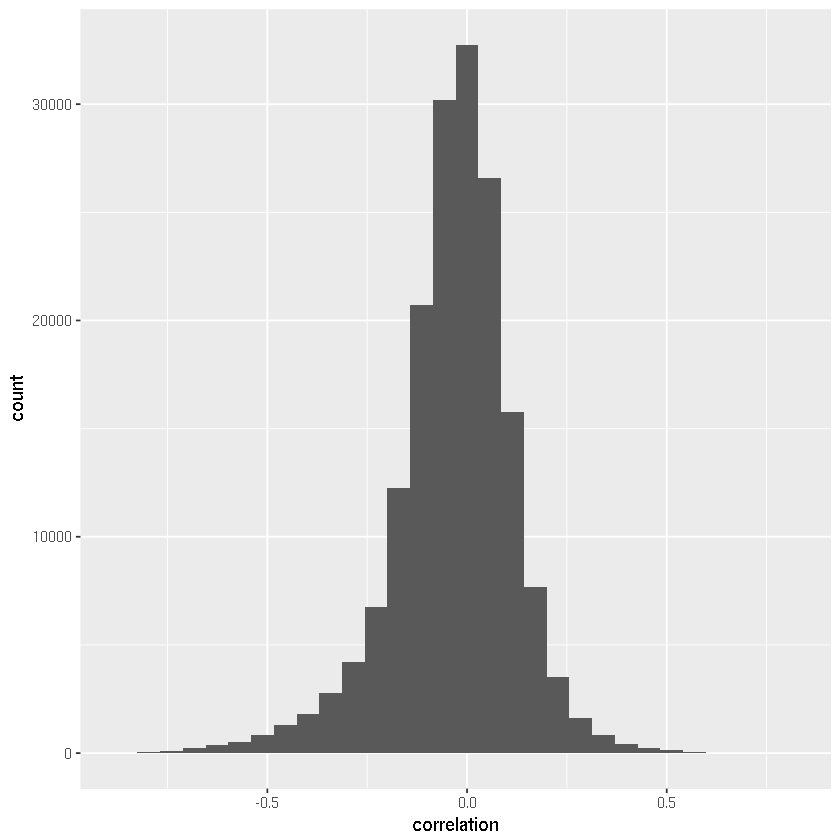

In [4]:
qplot(correlation, geom="histogram")

In [5]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.87778013 -0.10706584 -0.02188001  0.05552979  0.77326963

### Entire data set (M value)

In [1]:
load('../data/processed//CorrelationMvalue.RData')
length(correlation)

[1] 171715

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


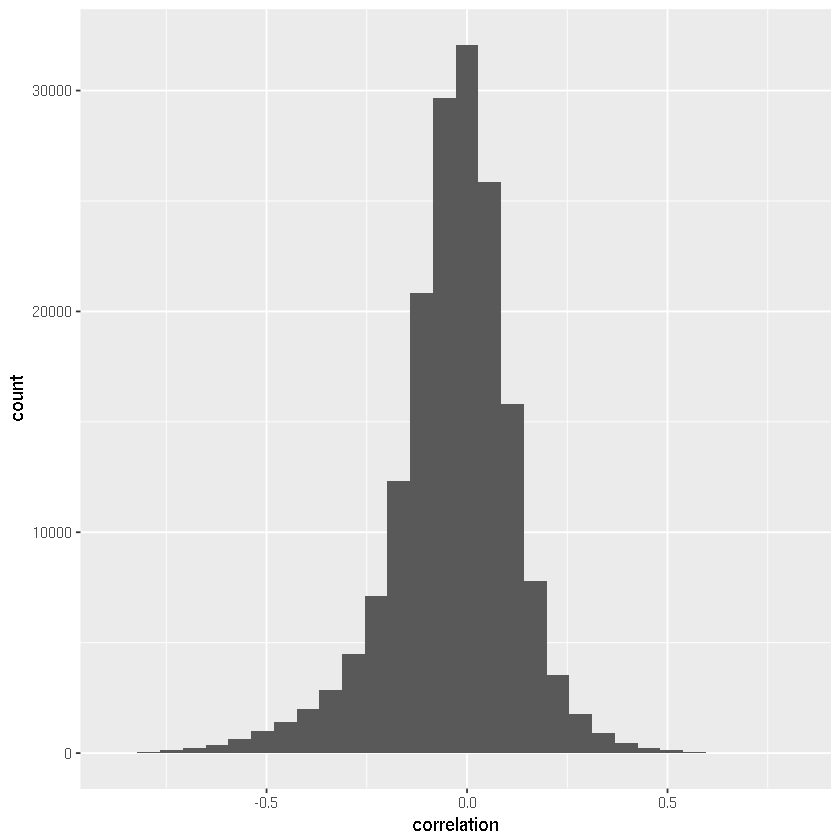

In [3]:
qplot(correlation, geom="histogram")

In [4]:
quantile(correlation)

0%         25%         50%         75%        100% 
-0.86615976 -0.11061239 -0.02342461  0.05547298  0.77844335

### Promoter region probes (Beta value)

### Promoter region probes (M value)

### Promoter + CGI/shore region (Beta value)

### Promoter + CGI/shore region (M value)